In [19]:
! pip install -r requirements.txt
! pip install -q librosa
! pip install -q numpy
! pip install -q pandas
! pip install -q IPython
! pip install -q matplotlib
! pip install -q scipy
! pip install -q scikit-learn
! pip install -q hmmlearn
! pip install -q pretty_midi


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip insta

In [20]:
import os
import shutil # move files and delete folders with files
import tarfile
import urllib.request # download files folder
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import IPython.display as ipd
import librosa, librosa.display
import re
import IPython # listen to sounds on Python
import pretty_midi

from scipy.io import wavfile
from scipy.spatial import distance_matrix
from matplotlib import colors
from itertools import product
from hmmlearn import hmm
from sklearn.metrics import f1_score
from utils.annotations import read_simplify_chord_file, simplify_predicted_chords, get_chord_notes, create_simple_midi
from utils.hmm_helper import calc_transition_prob_matrix, \
                             get_mu_sigma_from_chroma, \
                             create_ISPM,\
                             get_hmm_predictions, \
                             calc_initial_state_prob_matrix, \
                             adapt_initial_prob_matrix
from utils.files_processing import download_uncompress_data_to_local, \
                                   filter_lab_files, \
                                   delete_download_file, \
                                   delete_download_folder
from utils.signal import plot_signal, \
                         plot_spectra, \
                         stft_audio, \
                         calc_chromagram, \
                         chromagram_2_dataframe, \
                         get_frame_stats, \
                         get_annotated_chord_sequence, \
                         smooth_chords_by_beat
from utils.evaluation import calc_classification_stats, plot_performance


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Notebook for Pydata 2019 conference - https://de.pycon.org/program/pydata-yxndb9-hidden-markov-models-for-chord-recognition-intuition-and-applications-caio-miyashiro/

Backup Files and Pdf versions: https://drive.google.com/drive/folders/1YmfEPtX_QLlpo0sR0kQwFV4-Lz6Sd01W?usp=sharing. Note that this link will be deleted in **January 2020**

# Intro

Welcome to the workshop! Today, you will learn the concept of **Hidden Markov Models (HMM)**, which is a probabilistic framework to work with sequence data, such as speech and language processing and GPS positions. The main idea is to show everyone What is a HMM and provide them with sufficient basis so you can use it in your next projects. The concept will be presented with a specific story and application in music:

* "Given an input music signal, can we identify which chords were played and in which sequence?"
  
After this talk, I hope you'll be able to explain in common language what is a HMM, how it works and mainly, how you can use it next time you work with your sequence data (and learn a little about the best band in the world - The Beatles :-)). So lets go!

## Context

Chord recognition is one task from the field of Music Analytics [[1]](https://www.amazon.com/Music-Data-Analysis-Foundations-Applications/dp/1498719562), where we want to automatically extract characteristic features from musical pieces. For instances, besides chords, we could work to extract characteristics of tempo, key or instruments from our musical signal.  
  
> Imagine you're listening to youtube and suddenly hear a music that you enjoy. A lot. You feel you want to take your guitar and play around with your family and friends. However, as you search on the internet, you find no suitable chords on that song or any how-to-play that could make your get-together happier. What now?  
  
Imagine then being able to record the audio with your cellphone (or just send the youtube link) and have all the chords you needed in a few seconds. Your party is saved!  
    
Although the idea is simple, extracting information from music signals is still a big challenge. Music is a complex signal. Multiple voices, instruments and pre and post signal processing makes it difficult that we can get the features we want. Therefore, in order to work in our chord recognition problem, we need to understand a few processing techniques that'll make our lives "easier" for the task. Therefore, this is a small diagram covering the topics that we'll see today:

<img src="images/initial_diagram.png" style="height:100">  

<center>Overview</center>  
  
Lets begin!  

# How is sound stored and represented by a computer?

Lets take a clear sound of a piano playing a A3 and display it:

In [21]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html
Fs, x = wavfile.read("sounds/pianoA3.wav") 
IPython.display.Audio(x, rate=Fs)

The signal is represented with time on the x-axis and amplitude on the y-axis, where amplitude could be seen as the air pressure compression.

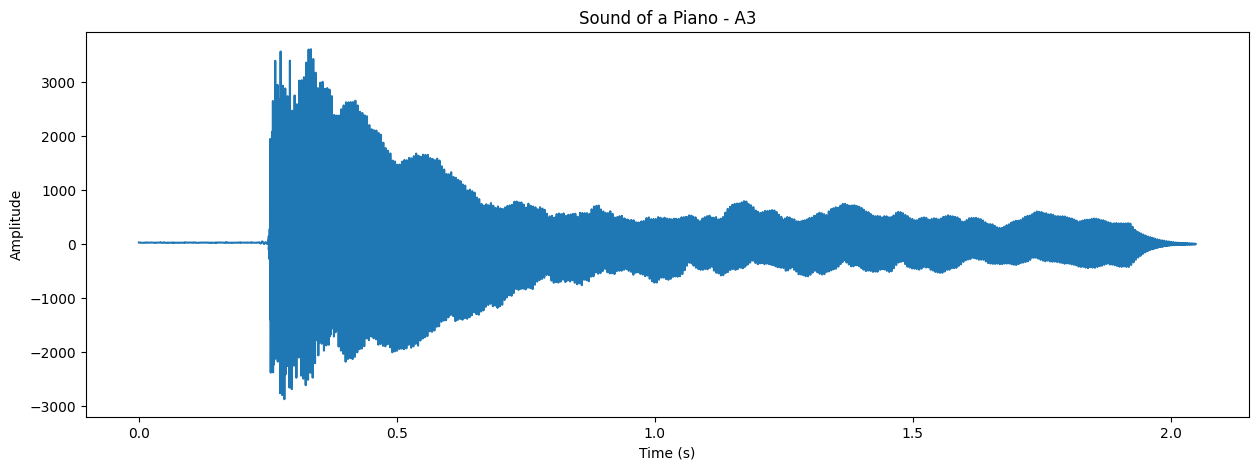

In [22]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 10

plot_signal(x, Fs, title='Sound of a Piano - A3', xlabel='Time (s)', ylabel='Amplitude')

**Zoomed Signal:**

If we look close enough, **from 0.5 to 0.55 seconds more exactly**, we can see that the signal is quite periodic. This periodicity represent one of the most basic sound qualities: the periodic variation of air pressure. In a micro scale, sequences of compressed and rarefied air reach our internal ears and are captured by highly specialised muscles, which turn them into electrical signals and finally into our perception of what a sound is. Check out this really cool summary on this Youtube Video - ["What is up with Noises? (The Science and Mathematics of Sound, Frequency, and Pitch)"](https://www.youtube.com/watch?v=i_0DXxNeaQ0).

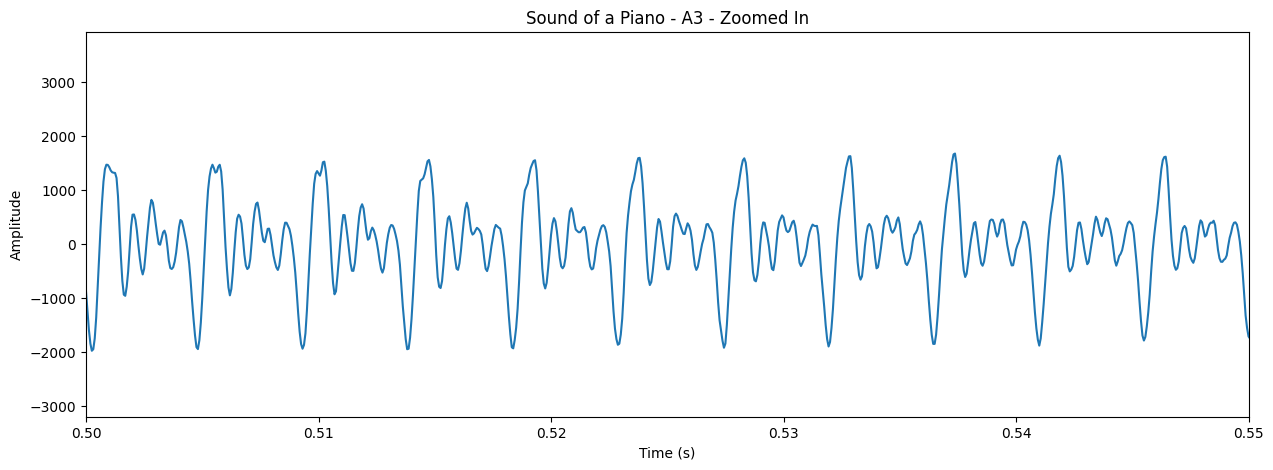

In [23]:
plot_signal(x, Fs, title='Sound of a Piano - A3 - Zoomed In', xlabel='Time (s)', ylabel='Amplitude')
plt.xlim([.5,.55]);

# From Time to Frequency Domain - The Fourier Transform (FT)

In western music, when we play a chord in our instrument, we are playing a set of specific notes. For instance we can differentiate a C minor from a C major by it's third (E or Eb). But, what if we could decompose any kind of sound in its respective notes (frequencies)? That's basically the Fourier transform. Despite its fancy name, this transformation basically just answer you the following question: "`What are the frequencies that, together, compose the sound I'm seeing?`"

<img src="images/fourier.gif" style="height:100">  

<center><a href=http://mriquestions.com/fourier-transform-ft.html>http://mriquestions.com/fourier-transform-ft.html</a></center>

Ok, when I said "*just answer x*" I was trying to make things simpler as they seemed. Let's take two examples of what the transformation can show us, lets hear two sounds, a whistle and a piano note, and lets see their Fourier transformation. If you don't want to understand the code below, it just takes the sound signal, perform the Fourier transform and plot the result, showing which frequencies (x-axis) are present in the signal:  
  
  
## Whistle

The whistling is at an A5, which is around [~880Hz ](http://pages.mtu.edu/~suits/notefreqs.html). When we perform the fourier transform on it, we can that the highest peak is at this frequency. There is some energy amplitude also around the peak frequency and that's probably because we don't produce a perfect A5 whistle, but rather some variational and approximated version of it.  

In [24]:
Fs_2, s_2 = wavfile.read("sounds/whistleA5.wav")
IPython.display.Audio(s_2, rate=Fs_2)

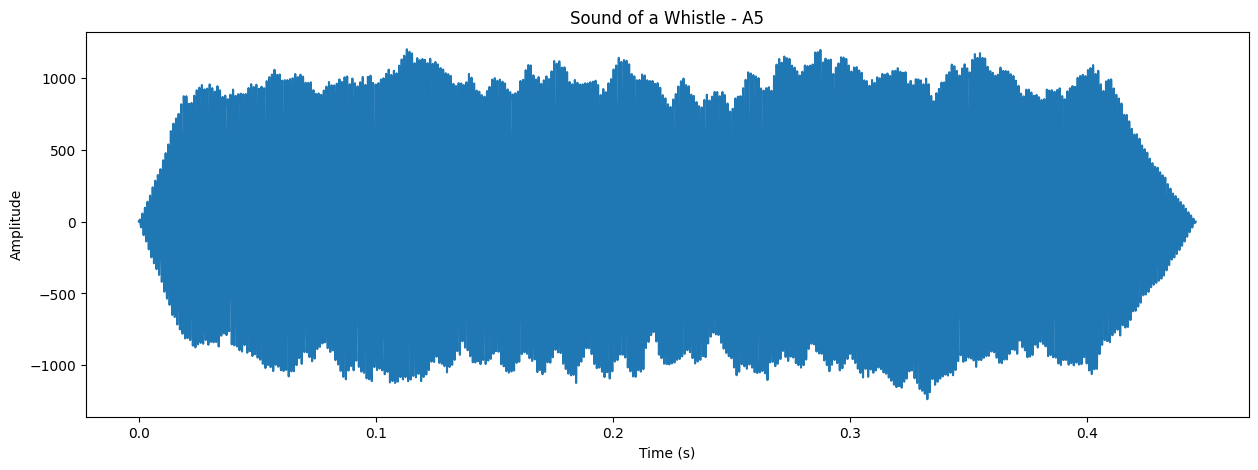

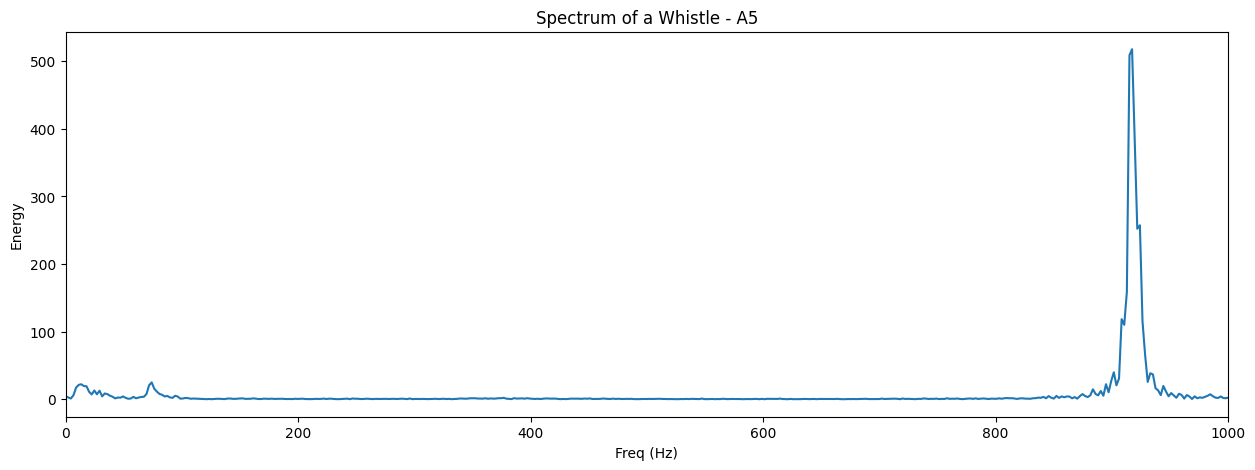

In [25]:
plot_signal(s_2, Fs_2, title='Sound of a Whistle - A5', xlabel='Time (s)', ylabel='Amplitude');
plt.show()
plot_spectra(s_2, Fs_2, max_freq=1000, title='Spectrum of a Whistle - A5', xlabel='Freq (Hz)', ylabel='Energy')

## Spectrum for Piano

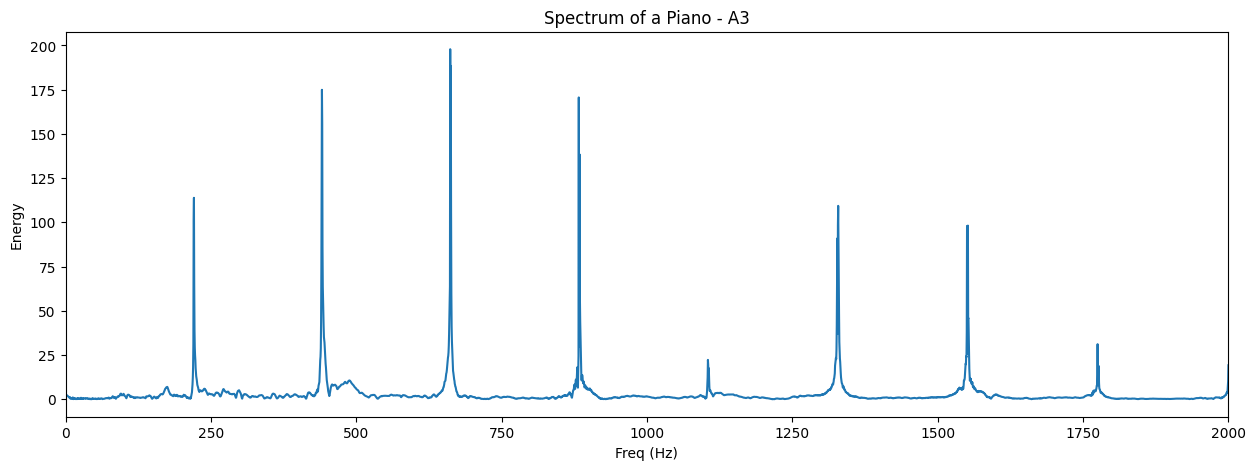

In [26]:
plot_spectra(x, Fs, title='Spectrum of a Piano - A3', xlabel='Freq (Hz)', ylabel='Energy', max_freq=2000)

Here we see how supposedly simple things already starts to complicate...Even though we will hear a single piano note, it frequency properties aren't as simple as the whistle sound, as it contains a diverse of [harmonics](https://en.wikipedia.org/wiki/Harmonic), *i.e.*, frequencies made of multiples from the original frequency. This frequently happens on (not only) string instruments, as the string oscillates on it's main frequency but each half of it also oscillates on a doubled frequency and so on. A good reference on string harmonics can be found [here](https://flypaper.soundfly.com/features/the-weird-and-creepy-world-of-string-harmonics) and a really nice video can be seen [here](https://www.youtube.com/watch?v=O1-CRFcX980).

<img src="images/harmonics.jpg" style="height:100">  
<center><a href="https://flypaper.soundfly.com/features/the-weird-and-creepy-world-of-string-harmonics/">https://flypaper.soundfly.com/features/the-weird-and-creepy-world-of-string-harmonics/</a></center>

The note we're playing is an A3, which have the fundamental frequency of ~220 Hz, but we see peaks of frequencies on 440, 660, 880 and so on. One interesting observation is that the main note doesn't necessarily has the biggest peak of between it and its harmonics.  

----------------
Finally, regarding the FT of signal, it takes a "picture" of it entirely and extract the frequency components out of it. This is good when we want to analyse the signal as a whole. However, sometimes we want to evaluate parts of it in sequence, such as in chord recognition, where the chords in a time window **will** be different sometime in the past or in the future. In order to have the fourier features for different parts of the music signal, we segment it in windows and apply the FT to each one of them: The **STFT**.  
  
# Short Time Fourier Transform (STFT)
  
Lets take an example. If we hear the melody below, we clear hear different pitches being whistled in sequence. However, if we take the FT of it, all frequencies will appear on the same "picture" and we'll lose information of who occurred first.  

In [27]:
Fs_3, s_3 = wavfile.read("sounds/whistleMelody.wav")
IPython.display.Audio(s_3, rate=Fs_3)

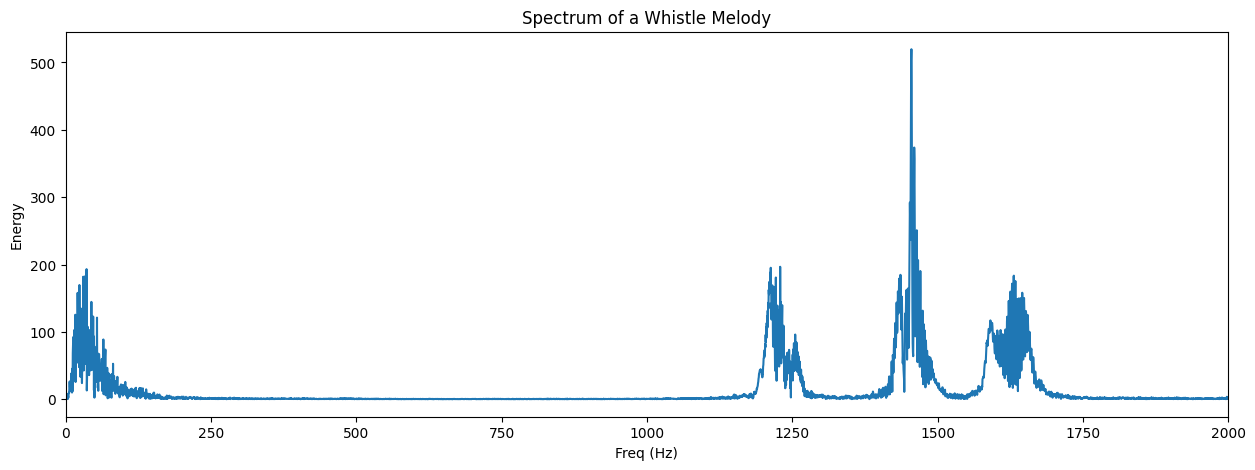

In [28]:
plot_spectra(s_3, Fs_3, title='Spectrum of a Whistle Melody', xlabel='Freq (Hz)', ylabel='Energy', max_freq=2000)

In order to visualise the STFT we need a different approach than FT. STFT has a new time dimension, while keeping the same frequencies dimensions from the FT. If we "bring" the right hand side of the FT plot (like above) to the top and concatenate them side by side, being each new item a FT of a time window, we can visualise this kind of information.   

* **X axis** will be time
* **Y axis** is the frequency
* color (**Z-axis**) is the energy, *i.e.*, the peak heights from the previous FT plots:

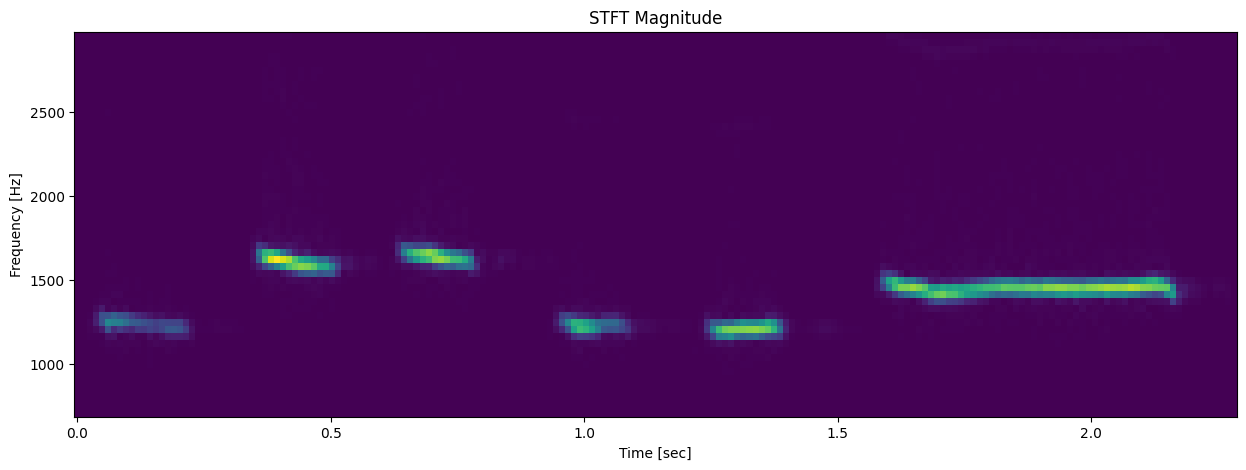

In [29]:
_, _, _ = stft_audio(s_3, Fs_3, True)

# Chords, what are they?

<img src="images/Natural-Minor-Chords.png" style="height:100">  
<center><a href="https://www.musical-u.com/learn/discovering-minor-chord-progressions-minor-chords-part-one/">https://www.musical-u.com/learn/discovering-minor-chord-progressions-minor-chords-part-one/</a></center>

We've talked a lot on the theory of the FT and STFT but not about our main task objective on identifying chords. After all, `what are chords?`.  
  
Chords are a set of 3 or more notes played together [[2]](https://www.coursera.org/learn/edinburgh-music-theory). These 3 notes are usually related to each other somehow (you can't play random 3 notes and call it a chord) and, depending on the notes choice made, they will have a specific role in your music, more specifically, in western music.  
  
The most common chords in western music are the major and minor chords. Possibly, any music could be composed by just using them and most instruments are capable of producing them, except melodic instruments such as violins or flutes.   
Chords can be pictured on a FT as multiple peaks from different notes played or as parallel lines in a STFT



## Features from STFT for Chord Recognition - Chromagram
  
In music, we have different pitches having the same note name. A low pitch A, a higher pitch A, even higher A, all have the same name A, differing just by a distance of an [octave](https://en.wikipedia.org/wiki/Octave). When we play a chord, in order to identify it, we don't need to know which octave of the note has been played, but only that the note itself has been played. Because of this feature, we can actually sum up the frequencies that belong to the same pitch. If we do that, we can have an idea of how much of each "note" we had on that time window, and this will be the **main feature** that will be used for our chord recognition problem.    
  
The technique takes the STFT of the music signal and, together with a [table connecting frequencies to pitches](http://pages.mtu.edu/~suits/notefreqs.html), if finds the energy of the overall pitch representation, sum them up and normalise them so the energy values stays between the interval [0,1].  
  
You can take a better look at the [chromagram function](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html) from [Librosa](https://librosa.github.io/librosa/index.html), which is the function we use to extract our chroma features.
  

In [30]:
let_it_be_intro_path = 'sounds/Let it Be Intro.wav'
x, Fs = librosa.load(let_it_be_intro_path)
ipd.display(ipd.Audio(x, rate=Fs))

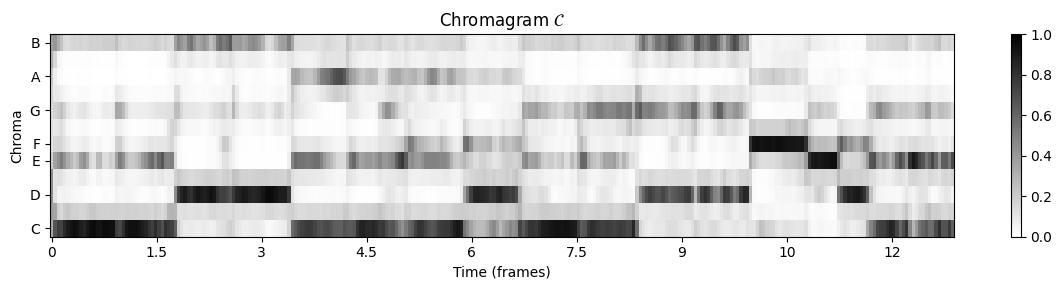

In [31]:
_ = calc_chromagram(x, Fs)

We can see that until the first ~1.5 seconds, there is a predominance of the C, E and G notes (and a little of B). This set of notes compose the music's initial chord, a **C major** chord. There is energy spread around other notes in a smaller way, which are probably harmonics from the three actually pressed key notes of the piano.  It seems it could be easy to identify the chords based on the chromagram. However, if we look at the following chord, there is a lot of energy around D, some more on B and almost nothing on G. This chord is actually a **G major** chord, but the D note was the lowest note in pitch on this chord, *i.e.*, an inverted chord. Therefore, we can't just look at the note with the biggest energy on it in order to classify the chord, we need more evidences. As it turns out, among chords, there's a high dependency of the current chord over the previous one **(*)**, so we need a tool that helps us to deal with that, so next we'll introduce `Markov Chains` and `Hidden Markov Chains`.  
  
(*) you can read more about chord dependency on western music Harmony, more specifically on [chord progressions](https://en.wikipedia.org/wiki/Chord_progression), but we're not going to cover it in this workshop

# Intro to Markov Chains - MC

<img src="images/markov_model.png" width="500">  
<center><a href="https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71">https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71</a></center>

**What is the chord on this time window given its chromagram and that the previous chord is a C major?**

This is the new adapted question for our original task on chord recognition. We've already seen how just using the chromagram as main features is not enough, as chords can have inversions and actually sometimes the [harmonics]( #Spectrum-for-Piano) effect can create enough noise to hide the main chord notes. Before we use the MC for our problems lets explain how it works with an easier example. For this, I'll mainly use the great explanation of [[3]](https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71) and create a simple MC over the following sentence in order to predict the next word, similar to our chord prediction definition:

> "One fish two fish red fish blue fish." <cite> -Dr. Seuss 🎩 </cite>
  
1. Adapting a little bit with some terms that are there but just hidden: 

> "-START- One fish two fish red fish blue fish -END-." <cite> -Dr. Seuss 🎩 </cite>  

One of the main features/assumptions of a MC is that the `current state of the model only depends on the **previous state** and not the ones that occurred before it`. Each state on this example can be a word and, in our problem, it would be a chord.  

If we want to predict the next word, given the immediately previous one, we can process our sentence so we see this kind of relationship:

<img src="images/markov_model_tokens.png" width="500">  
<center><a href="https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71">https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71</a></center>  
  
Considering only this sentence, if you saw the token <START>, you would be sure that next word is `One`. However, if you saw the word "fish", then the possible next words could be `two`, `red`, `blue` or `<END>`, *i.e.*, there'll be more uncertainty over this word. We can represent this uncertainty by a graph and show what are the possibilities of going from one word to another and, in case there are more possibilities, we can generate the probabilities for those events:
    
<img src="images/markov_models_graph.png" width="500">  
<center><a href="https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71">https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71</a></center>  
  
Now, imagine the same for our music problem. We look at some music sheet, record this chord *x* chord interactions and plot the same kind of graph. We could end up with something like this:   
  
<img src="images/markov_model_chord_graph.png" width="500">  

As we only analysed one music, we only have 1 C major chord after -START-. From there, we can go and go back to different chords until we end up at -STOP- and stop our chords prediction.  
  
With a MC, if we have an initial chord, we can then predict what could be the next ones based on the previous chord. This would be already good, **if** we had the exact name of the played chord at hand. Remember that the input for our task today was a music signal. Behind those amplitudes and energies, the chord change chain is running behind it, "*hidden*". In order to be able to connect our chord chain with the windowed music signal, we need a extra feature, which is the feature of `Hidden Markov Models`.
 

# Hidden Markov Models - HMM

<img src="images/hidden_markov_model_summary.png" width="500">
<center>Summary of main features of a Hidden Markov Model</center> 


Examples will be adapted from [[4]](https://web.stanford.edu/~jurafsky/slp3/8.pdf) and [this](https://www.youtube.com/watch?v=kqSzLo9fenk) youtube tutorial.  
  
"A Markov chain is useful when we need to compute a probability for a sequence of observable events. In many cases, however, the events we are interested in are hidden hidden: we don’t observe them directly. For example we don’t normally observe the chord labels in a music audio signal" [[4]](https://web.stanford.edu/~jurafsky/slp3/8.pdf). Rather, we see the audio sound and must infer the chords out of it. We call the sequence hidden because they are not observed.   
  
The HMM will allow us to add the features to our observation and keep with the same framework of that MC. You can check out the mathematical formulation for HMM at the [Appendix](#Appendix) section but here we will stay with the main intuitions.  
  
The main answer that a HMM can give us is:
* What is the most probable sequence of chords for a given sequence of observations?  

In order to answer this question we will need a few things from the MC and some new features:
1. **Chord Transition Probability Matrix**: These are the notes probabilities explained in the MC section but having the chord transition probabilities instead.
2. **Emission probabilities**: Probability of an observation to belong to each one of the chords $\mathbb{P}(observation|chord)$.  
3. **Initial State Probability Matrix**: Indicates what is the probability of a sequence to begin with a specific chord.
  
However, where we're going to extract these data from?  

# Annotation + Music Data - The Beatles

In order to be able to generate the probabilities above, we need:
* The music files in order to extract the chromagrams
* An annotaded dataset, so we can join the chord labels with the corresponding windowed chromagrams. 

For the musics, we can obtain the music files by purchasing them online. For this workshop I'll be providing the files :)  
  
For the annotaded dataset, luckily, some researches invest time on creating and publishing them, so they can be used as standards for a specific research domain or used as machine learning models tasks baselines. Here, we'll investigate the dataset generated by Harte (2010)[[5]](https://code.soundsoftware.ac.uk/attachments/download/330/chris_harte_phd_thesis.pdf). Harte, together with other musicians and researches, manually extracted features from 120 musics from The Beatles, including beats, key changes and chords. You can download all annotations on their [website](http://www.isophonics.net/content/reference-annotations-beatles)
  
For this workshop, I've already download, processed and joined them together with their respective musics and they're in the `lab_and_music` folder, together with their respective annotation files.
  
## Read and Simplify Annotations

Chords can be complex and subjective some times. In western music theory, chords can have functions and, even though a C# chord consist of exactly the same notes of a Db, in theory, they influence the music with different "functions" or emotions so to say. In order to simplify our problem, we'll only work with the main types of chords, major and minor chords. We'll exclude, for example, 7th chords or diminished or augmented chords. This will make it easier for our HMM understand and predict chords. In order to understand what we want to do with all files and music files and also to check if our assumptions for our task for today works, I'll show an example with one file first:  

In [32]:
DEST_FOLDER = 'lab_and_musics'

lab_file_path = f'{DEST_FOLDER}/Let_It_Be.lab'
chords_annotation = read_simplify_chord_file(lab_file_path,process_silence=True)
chords_annotation.head()


,start,end,chord
0,0.000000,0.175157,C
1,0.175157,1.852358,C
2,1.852358,3.454535,G
3,3.454535,4.720022,A:min
4,4.720022,5.126371,A:min


## Calculate framed Chromagram and join with chord labels

Now that we have the annotations with the time period that which chord was played on a music, we need to join it with our chromagram features so we can "train" our HMM. The idea is to create a definition of "what is a C Major chord in a chromagram" so we can create then our **emission probabilities**.  
  
Before merging our chromagram with the annotation files, we need to know how much time each of our chromagram windows takes in order to be able to merge. For that, we first use the function `get_frame_stats`, sending the windowed chromagram, the signal and its sampling frequency in order to know how many seconds each window is.  
  
With these informations, we can then say which chord was being played in each one of the windows.

In [33]:
x, Fs = librosa.load(let_it_be_intro_path)
let_it_be_chromagram = calc_chromagram(x, Fs, plot=False)
frames_per_sec, frame_duration_sec = get_frame_stats(chromagram=let_it_be_chromagram,
                                                     signal=x, 
                                                     Fs=Fs)

pcp = chromagram_2_dataframe(let_it_be_chromagram, frame_duration_sec, test_version=True)

pcp['chord'] = get_annotated_chord_sequence(pcp, chords_annotation, test_version=True)
pcp.head()

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,start,end,chord
0,0.328111,0.392393,0.430106,0.430240,0.171732,0.105401,0.109222,0.133969,0.166579,0.214087,0.308256,0.359433,0.000000,0.046419,C
1,0.664177,0.352761,0.109753,0.110626,0.366218,0.163517,0.087432,0.182613,0.090595,0.068443,0.157639,0.412985,0.046419,0.092837,C
2,0.754787,0.184479,0.045408,0.124241,0.429377,0.168346,0.106199,0.206016,0.082103,0.026816,0.040539,0.321305,0.092837,0.139256,C
3,0.734501,0.146537,0.047722,0.111363,0.507049,0.167623,0.137559,0.243638,0.065114,0.015817,0.024087,0.236238,0.139256,0.185674,C
4,0.833918,0.198937,0.056337,0.078762,0.421175,0.114144,0.089200,0.182769,0.042916,0.006769,0.013399,0.147586,0.185674,0.232093,C


## Calculate State Transition Matrix

We're finally ready to calculate our first needed matrix: **Transition Probability Matrix**, *i.e.*, the probability of changing from one chord to another from window to window.

For this, we'll use the `calc_transition_prob_matrix`, which will run through all our chord in the dataframe and count all chord-to-chord transitions that it sees. Finally, in order to become a probability, we will normalise all values so the probabilities of going from one chord to all others is always 1.

In [34]:
transition_matrix = calc_transition_prob_matrix(pcp, test_version=True)
transition_matrix

,A:min,C,F,G,<END>
A:min,0.972222,0.000000,0.027778,0.000000,0.0
C,0.000000,0.980198,0.000000,0.019802,0.0
F,0.000000,0.028169,0.971831,0.000000,0.0
G,0.014493,0.000000,0.014493,0.971014,0.0
0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.0


## Emission Probabilities 

<img src="images/emission_probability_example.png" width="600">
<center>A friendly introduction to Bayes Theorem and Hidden Markov Models - <a href="https://www.youtube.com/watch?v=kqSzLo9fenk&t=1728s">https://www.youtube.com/watch?v=kqSzLo9fenk&t=1728s</a></center>  

If you recall from the [intro to HMM](#Hidden-Markov-Models---HMM), the emission probabilities connect our observations (visible) with our probabilistic network (hidden), showing the probability of an observation belonging to a state (chord) $\mathbb{P}(obs|state)$. In order to calculate them, we have to think differently based on the type of the observation we have:  
  
* **Categorical**: Observations have distinct values. For example, classifying the weather based on people's emotion, such as sad, neutral or happy (example [here](https://www.youtube.com/watch?v=kqSzLo9fenk)).  
   
* **Continuous**: Observations can take numerical, or multi-dimensional numerical, fields. The example of chord recognition is this case, where our observations are the energies of each note present on the chromagram and can have any number in between a pre-defined scale.  
  
### Emission Probabilities for categorical observations

When we deal with categorical observations, the task of calculating $\mathbb{P}(obs|state)$ is based on counting the relationship between each observation and the corresponding state. Remember that a HMM attributes a state to every observation in the sequence. So, for example, if we have the amount of times that I observed the following relationship frequencies in my **historic database**:  
* Sad: {'Sunny': 100, 'Rainy':400}
* Neutral: {'Sunny': 300, 'Rainy':300}
* Happy: {'Sunny': 500, 'Rainy':100}  

We just need to normalise our counts so we can have our **emission probabilities**. So first we calculate the sum of each variable as a normalisation factor:
* Sum of observations in "Sad"     = 100 + 400 = 500
* Sum of observations in "Neutral" = 200 + 200 = 400
* Sum of observations in "Happy"   = 500 + 100 = 600  
  
And apply the normalisation factor to our conts in order to have probabilities:  
  
* Sad: {'Sunny': 100/500, 'Rainy':400/ 500}
* Neutral: {'Sunny': 200/400, 'Rainy':200/400}
* Happy: {'Sunny': 500/600, 'Rainy':100/600}  
  
=  
  
* Sad: {'Sunny': 0.2, 'Rainy':0.8}
* Neutral: {'Sunny': 0.5, 'Rainy':0.5}
* Happy: {'Sunny': 0.83, 'Rainy':0.17} 

### Emission Probabilities for continuous observations  

With continuous variables, there is no count that we can do in our historical database. For instance, if we were trying to predict the weather given the temperature. We wouldn't have only 3 states, like "Sad", "Neutral" and "Happy" as in the example above, but instead, we'd have many (infinite) possible different observations that related to "Sunny" or "Rainy", like these 3 examples:
* $\mathbb{P}(temp=20.7|sunny)$ **or** 
* $\mathbb{P}(temp=20.07|sunny)$ **or**  
* $\mathbb{P}(temp=20.007|sunny)$ **and so on...**  
  
In this cases, we need to do some **prior** assumptions on how our states looks like considering our variables of interest, such as *temperature* in this example.

> "Summer days in São Paulo - Brazil tend be between 30 and 40 degrees celsius"   
  
> "Winter is a summer day that didn't work. Temperatures can be between 15 to 25 degrees celsius"  
  
We usually have this kind of talks with our international friends explaining some general rule about a system. We usually speak about it based on our previous experiences and/or generalisation process. If we wanted to have the same ideas about a country that we haven't been yet, what could we do?  
  
* One thing to do would be to take temperatures online from a weather website, observe it for different weathers and create such temperature interval (or more generically, $assumption$) based on the data you have. Then, if you observe a temperature on a new day, you'd be able to make an educated guess of how the weather could look like. But still, **how to calculate probabilities on this continuous variables?**  
  
<img src="images/normal_distributions_.png" width="300">
<center>Example of Probability Distribution for Temperature</center> 

If we're calculating probabilities over continuous variables, we have to assume our data follows a specific distribution. For this chord recognition task and this temperature example, we'll assume that our observations follow a **normal distribution** [[6]](https://pt.coursera.org/lecture/probability-intro/normal-distribution-M71Nv).  Assuming a normal distribution for our temperature example states that:
* The temperature on different weather statuses has an average temperature
* The temperature can vary around this mean value, and the scale of the deviation from the mean value is defined by its variance.  

and the formula to calculate the probability of observing a temperature (close to) $t$ given the weather $w$ defined by its mean $\mu_{weather}$ and variance $\sigma^{2}_{weather}$ is: 

$$\mathbb{P}(t|\mu_{weather}, \sigma^{2}_{weather}) = \frac{1}{\sqrt{2\pi\sigma^{2}}} e ^{-\frac{(t-\mu)^2}{2\sigma^{2}}}$$  
  
oooor we call the equivalent python function in [scipy.stats.norm.pdf](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html) to check for that :D  

### Emission probabilities for chords and chromagrams  
  
> Usually for a C major chord, we have this chromagram picure  
  
The temperature example could work if we only had 1 variable for every state. Instead, in our chromagram, we have 12 variables, the energy of each one of the notes of the chromatic scale (A, A#, B, C and so on...). How do we do a probability of 12 variables belonging to a certain chord?  

Lets think on the question, `"What is the probability of a chromagram showing a C major?"`. In this case, we'd expect a high energy on the notes `C`, `E` and `G` (major triad) and supposedly nothing else. The C major chord expect that the three notes have a high energy and expect that, if one is higher than another, which could happen, the chord would have some tolerance because it knows the energy of each note can vary **and** the energy on one note compared to other notes can also vary. In this case, the 12-variables probability distribution is just an generalisation of the original normal distribution we've seen, called [**multivariate gaussian distribution**](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). Instead of having one expected $\mu$ and $\sigma^{2}$ for each chord, we'll have a set of 12x $\mu$ and a set of $\sigma^{2}$ for each note and an extra statistic showing how the notes' energies vary among themselves, called [covariance](https://pythonfordatascience.org/variance-covariance-correlation/).  

Finally, the assumption we're going to make for each chord's note energy distribution will be taken from the data, *i.e.*, we will calculate the notes' mean and covariance from each labeled chord of our chromagram.

In the same way for one dimension, calculating the probability $\mathbb{P}(chromagram|\mu_{chord}, \sigma^{2}_{chord})$ has a specific (hard) [equation](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Density_function). Lucky for us, we'll leave this responsibility to the HMM package we're going to use, so we just need to calculate the multivariate gaussian parameters. So lets go for it:

## Calculate  Emission Probabilities 

Calculate distribution assumptions of each chord according to the mean energy in the labeled chromagram.
* For a HMM with $M$ states, `mu_array` will be shape [$M$, 12], where 12 are the 12 notes from the chromagram. It'll show the average energy in each one of the 12 notes for each of the chords.
* For each chord of our HMM, we'll have a matrix of shape [12,12] for each note. It'll tell the HMM how, in each chord, the notes vary among themselves. For example, in a **C major** chord, we expect that, when the `C` note is high, the notes `E` and `G` are expected to be high as well. In this condition, `states_cov_matrices` is of shape [$M$,12,12]. The function `get_mu_sigma_from_chroma` runs a `for` loop on every chord and their respective chromagrams and then calculates the mean energy and their covariance.

In [35]:
mu_array, states_cov_matrices = get_mu_sigma_from_chroma(pcp)
# states_cov_matrices[0:2] = 0 # turn cov matrices of <START> and <END> to from nan to 0


##  Calculate Initial State Probability Matrix - ISPM

After all the hard work, we just have to calculate the last and easiest matrix. The reason we need to do this is in the way HMM works, on it's mathematical formulation, which can be seen in the [Appendix](#Appendix). For every step in the algorithm, we always calculate $\mathbb{P}(chord_{i}|chord_{i-1})$, *i.e.*, the probability of observing a chord in a window given the previous chord at the previous window. The **ISPM** works just to sort out this computation for the **first** state. At this situation, we don't have the previous chord so we replace it by the choosing a chord to begin with at random, with given custom probabilities.  
  
In this case, in order to calculate our ISPM, we ran through all our *.lab* files, count all the initial chords, *i.e.*, first chord of the music **except for silence**, and then normalise the number so the sum of the ISPM = 1.  
  
If we run the `calc_initial_state_prob_matrix` function below, we will see that different music start with different chords, so we end up with a ISPM containing multiple chords. However, because we're just doing a first version with 1 partial song (Let it Be), we shouldn't include chords that doesn't exist in the song in our HMM. In order to achieve that, we execute the follow up function `adapt_initial_prob_matrix` so we filter only the chords that exists in our chromagram from the ISPM and them normalise the probabilities again so the sum of it = 1 again.

In [38]:
initial_state_probs = calc_initial_state_prob_matrix(process_silence=True)
display(initial_state_probs[:5])

initial_state_probs = adapt_initial_prob_matrix(initial_state_probs, transition_matrix)
display(initial_state_probs)

AttributeError: 'Series' object has no attribute 'append'

# Initiate and Predict with Hidden Markov Model

We're **finally** ready to build our HMM! For that, we're going to use the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) python package. This package abstract a few complicated mathematics for us, leaving an interface similar to sklearn machine learning packages, where we build and then predict over new observations.  
  
Exclusively this function, I'll leave it on the notebook so we can better build and evaluate it. Lets take a look:

* Because we're working with continuous emission probabilities, we build a `hmm.GaussianHMM` first and send the number of states. `covariance_type="full"` defines that the HMM understand that the notes can have a relationship, *i.e.*, the amount of energy in one note is not **independent** of anyone else.  For different HMM with different types of emission probabilities, you can check out their [documentation](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#available-models).
* We set the Initial State Probability Matrix
* Then Transition Probability Matrix
* `means_` and `covars_` indicates the two parts of our emission probability as explained in section ["Emission Probabilities"](#Emission-Probabilities)  
  
That's it! Our HMM is built and ready to predict on new chromagrams!  

In [18]:
def build_gaussian_hmm(initial_state_prob, transition_matrix, mu_array, states_cov_matrices):
    # continuous emission model
    h_markov_model = hmm.GaussianHMM(n_components=transition_matrix.shape[0], covariance_type="full")

    # initial state probability
    h_markov_model.startprob_ = initial_state_prob
    # transition matrix probability
    h_markov_model.transmat_ = transition_matrix.values

    # part of continuous emission probability - multidimensional gaussian
    # 12 dimensional mean vector
    h_markov_model.means_ = mu_array
    # array of covariance of shape [n_states, n_features, n_features]
    h_markov_model.covars_ = states_cov_matrices
    return h_markov_model
    
h_markov_model = build_gaussian_hmm(initial_state_probs, transition_matrix, mu_array, states_cov_matrices)

We see below that the HMM doesn't save the state label (chord name). The states are saved on the same order they appeared in the transition probability matrix. Therefore, in order to account for that, we need to reconvert the numbers to the corresponding chords.  
  
At the end, we have the predicted chords for our sequence of chromagrams :D  

In [ ]:
COL_NAMES_NOTES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

chord_ix_predictions = h_markov_model.predict(pcp[COL_NAMES_NOTES])
print('HMM output predictions:')
print(chord_ix_predictions[:50])

# create map between numerical state index and chord
chord_numbers = range(len(mu_array.index.values))
chords = mu_array.index.values
ix_2_chord = {ix_: chord_str for ix_,chord_str in zip(chord_numbers,chords)}

chord_str_predictions = get_hmm_predictions(chord_ix_predictions, ix_2_chord)
print('Translated chords HMM output predictions:')
print(chord_str_predictions[:50])

pcp['predicted'] = chord_str_predictions

# Visual Evaluation

<img src="images/hidden_markov_model_evaluation_.png" width="500">  
<center>Predictions from HMM</center>

Nice! It seems we finally have predictions from our HMM. As always, **retrieving and pre-processing the data takes way more time than creating the model**.  

With the predictions, the mandatory follow up question we need to do is: `How good are my predictions?`  

Considering we're classifying our windowed chromagrams into one of the **12 possible chords**, we call this as a [multiclass classification problem](https://pt.coursera.org/lecture/python-machine-learning/multi-class-classification-V2gAg). When we deal with this kind of classification, one way to evaluate it is through a metric called [F1-Score](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9). I'll leave the mathematics for the [multiple online tutorials](https://pt.coursera.org/lecture/machine-learning-with-python/evaluation-metrics-in-classification-5iCQt) out there but, in short, the F1-Score tells us how well are predicting our chords, from a value of 0 to 1.  
  
The F1-Score considers metrics coming from the statistical classification field, called [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62), which is built by the following metrics:  
* True Positive (TP)
* True Negative (TN)
* False Positive (FP)
* False Negative (FN)
  
Lets investigate the definitions by the following image:
  
<img src="images/metrics_confusion_matrix.png" width="400">  
<center><a href="https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62">https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62</a></center>  
  
* True Positive: Original window chord: `C`. Predicted: `C`
* True Negative: Original window chord: **not** `C`. Predicted: **not** `C`. Makes more sense in binary classification schemes, not in multi class problems.
* False Positive: Original window chord: **not** `C`. Predicted: `C`. FP is looked by the perspective of predicting a `C` chord
* False Negative: Original window chord: `C`. Predicted: **not** `C`. FN is looked by the perspective of predicting a `C` chord
  
So, besides, looking at the F1-Score, we can also look at the temporal dimension and see how the confusion matrix metrics developed over time.  
* `Was there any chord that the HMM didn't get correctly at all?`  
* `Any weak/strong points where the HMM performs better?`  


## Calculate True Positive, False Positive and False Negatives

Looking below, we can see that our HMM manage to correctly predicts the 12 seconds of the music "Let it Be" from the Beatles. Although we can argue this is just one single music and from a piece which just 1 instrument plays, **this result is quite important to understand that our model is actually "learning" something, or that the features bring some value for the prediction**.  
  
I like Andrej Karpathy's twitter on Deep Neural Networks. Although far from being similar models, I found it a valid tip for every new ML technique you try :)  

<img src="images/andrej_twitter.png" width="350">  
<center><a href="https://twitter.com/karpathy/status/1013244313327681536">https://twitter.com/karpathy/status/1013244313327681536</a></center>  

In [ ]:
true_positives, false_positives, false_negatives, f1_score_= calc_classification_stats(pcp)

print(f'F-Score: {round(f1_score_,2)}')
plot_performance(true_positives, false_positives, false_negatives, frame_duration_sec)    


# Execute predictions

Based on the window prediction, we can actually regenerate the sound as a midi file. Because we don't want to play a note for every chromagram window, we first simplify the chords again, but this time over time. If two adjacent windows have the same predicted chord, we join them both and adjust the `start` and `end` time to encompass for them.  
Finally, we use [pretty-midi](https://github.com/craffel/pretty-midi) python package in the `create_simple_midi` in order to generate the sounds. The cool thing about this package is that we can just configure which notes to play and from which to which second we want, making it pretty smooth to use.  



In [ ]:
chords_simplified = simplify_predicted_chords(pcp)
chords_simplified

In [ ]:
create_simple_midi(chords_simplified, tempo=librosa.beat.tempo(x, Fs)[0])

In [ ]:
ipd.display(ipd.Audio(x, rate=Fs))

# Try with whole song

Ok, we overtfitted our model and saw that it manages to extract the pattern from the chromagram and the temporal chord sequence pattern in order to get the chord prediction right. If we want a more useful model, we want to be able to train it with multiple songs and predict on new ones.  
  
In order to facilitate our training process, I've joined all the functions we've seen into a **training pipeline**, so it becomes easier to train and predict with multiple music files. All the action will be executed thought the `train_pipeline` and evaluation will be made through `get_predictions` and `evaluate`.


## Build Pipeline

In [24]:
def build_chroma(song_path, process_silence=True, test_version=False):

    # input data -> signal, sample frequency, chromagram and annotated dataset
    x2, Fs2 = librosa.load(song_path)
    C2 = calc_chromagram(x2, Fs2, False)
    frames_per_sec, frame_duration_sec = get_frame_stats(C2, x2, Fs2)
    annotation_file_path = f"{song_path.split('.')[0]}.lab"
    chords_annotation2 = read_simplify_chord_file(annotation_file_path,process_silence=process_silence)

    pcp2 = chromagram_2_dataframe(C2, frame_duration_sec, test_version=test_version)
    pcp2['chord'] = get_annotated_chord_sequence(pcp2, chords_annotation2, test_version=test_version)
    return x2, Fs2, pcp2

def calc_hmm_matrices(chromagram, process_silence=True, test_version=False):

    ##### HMM parameters
    # Transition Matrix
    transition_matrix2 = calc_transition_prob_matrix(chromagram, test_version=test_version)
    # Adapted Initial Probability Matrix
    init_states2 = calc_initial_state_prob_matrix(process_silence=process_silence, annotations_folder_path='lab_and_musics')
    filtered_initial_states2 = adapt_initial_prob_matrix(init_states2, transition_matrix2)
    # mu and covariance matrices
    mu_array2, states_cov_matrices2 = get_mu_sigma_from_chroma(chromagram)
    return filtered_initial_states2, transition_matrix2, mu_array2, states_cov_matrices2

def get_predictions(h_markov_model, prediction_dict, song_path, test_version=False):
    # get predictions
    signal, sr, chromagram = build_chroma(song_path, process_silence=True, test_version=False)
    chord_ix_predictions2 = h_markov_model.predict(chromagram[COL_NAMES_NOTES])

    chromagram['predicted'] = get_hmm_predictions(chord_ix_predictions2, prediction_dict)
    chromagram['predicted_cluster'] = smooth_chords_by_beat(chromagram, signal, sr, predicted_col='predicted', n_beats=1)
    return chromagram

def evaluate(chromagram, only_f1=False):
    return calc_classification_stats(chromagram, predicted_col='predicted_cluster', only_f1=only_f1)

##### EXECUTION
def train_pipeline(songs, test_version=False):
    chromagram = pd.DataFrame()
    for song in songs:
        signal, sr, chromagram_one = build_chroma(song, test_version=test_version)
        chromagram = pd.concat([chromagram, chromagram_one], ignore_index=True)
    initial_states, transition_matrix, mu_array, states_cov_matrices = calc_hmm_matrices(chromagram, test_version=test_version)
    ix_2_chord = {ix_: chord_str for ix_,chord_str in zip(range(len(mu_array.index.values)),mu_array.index.values)}
    h_markov_model = build_gaussian_hmm(initial_states, transition_matrix, mu_array, states_cov_matrices)
    return h_markov_model, ix_2_chord


In [ ]:
song_path = 'lab_and_musics/Let_It_Be.mp3'
h_markov_model, ix_2_chord = train_pipeline([song_path], test_version=True)

# new prediction
chromagram = get_predictions(h_markov_model, ix_2_chord, song_path)
print('1 Song F1-Score:')
evaluate(chromagram, only_f1=True)


In [ ]:
chords_simplified = simplify_predicted_chords(chromagram)
create_simple_midi(chords_simplified, tempo=100)

In [ ]:
x, sr = librosa.load(song_path)
ipd.display(ipd.Audio(x, rate=sr))

## Predict

For the final combo, lets see how it goes with the 50 songs that you have available, together with their respective chord annotations.

In [28]:
songs = []
for file_name in os.listdir('lab_and_musics'):
    if(file_name.endswith('.mp3')):
        songs.append(f'lab_and_musics/{file_name}')

h_markov_model, ix_2_chord = train_pipeline(songs[:35])

In [ ]:
ind_f1_score = []
for song in songs[-15:]:
    chromagram = get_predictions(h_markov_model, ix_2_chord, song)
    ind_f1_score.append(evaluate(chromagram, only_f1=True))
    
plt.hist(ind_f1_score)
plt.title('F1-Score distribution for unobserved musics');

# Conclusion

For this first iteration, we've seen our HMM performs poorly in general. But we had lots of learnings for possible next steps!   
  
* First of all, just by hearing the complete 'Let it Be' music, we can notice how the Voice and Drums hampers the chord recognition. Searching in the literature, in the source separation domain, it seems it's easier to extract drums out of the sound, like this Librosa function on [Harmony Percussion Source Separation](https://librosa.github.io/librosa/generated/librosa.effects.hpss.html) - (HPSS).  
  
* Secondly, at least in tradition rock/pop songs, chords tend to stay within the beats of a song, not changing every chromagram window. In this work, I secretly used a Librosa function on [beat detection](https://librosa.github.io/librosa/generated/librosa.beat.beat_track.html) but more work could be devoted to this.  
  
* Thirdly, a music theory based feature. Analysing the chord predictions, I've notices that a common error that the HMM makes is to confuse a note by its VI degree. This is more music especific but, in Harmonic fields, [the first chord of the field and its corresponding VI degree have the same notes](http://www.simplifyingtheory.com/relative-minor-major/). For instance, a C major chord and a A minor are composed by the same 3 notes - `C`, `A` and `E`. This makes the transition matrix sometimes go from `C major` to `A:min` and, because the transition probability matrix doesn't have a path from `A:min` back to `C major`, it doesn't come back. Check the transition probability from the [whole music evaluation with 'Let it Be'](#Try-with-whole-song). In this case, we could adapt the transition probability matrix to allow a connection between every chord and their respective VI degree so that, in case of mistakes by the HMM, we leave a space so it can fix itself.

* Lastly, transition probability matrices could be different based on the key tonality of the music. If we manage to extract the music's tone, we could choose specific key-tonality transition probability matrices that could adapt to our chord sequence in a better way. 
    * For instance a transition probability between a `C` and a `B` in a `C major` tone would be higher than the same transition but for musics in a `F major` tone (no note `B` in the scale)

**In the end, it'd be all about the features** :)

## What could we do even more?

* Extract lyrics from websites and insert them into the beat + chord structure and produce a pdf with lyrics + chords
* Could we use music websites as annotaded chord songs? We would need to find a way to match the written chords with time beats and use them as proxy for chord start and end annotation.
    * With the bigger amount of songs, we could even think on LSTMs for chord prediction
    
# Appendix

In this section I left some material for the more mathematical formulations inclined. It helps to answer some things that I've skipped for the sake of the material's simplicity for the workshop.  

## Fourier Transform
  
If you want to understand better about Fourier Transforms, there're lots of resources on the internet. Specifically for me, a basic reference that helped me to understand it from the beginning was [Think DSP](http://shop.oreilly.com/product/0636920044970.do) from O'really  
## Choosing window size for STFT

Even though I tried to make the Fourier transform is easy, it actually has a lot of heavy mathematics envolved, just check its [Wikipedia Page](https://en.wikipedia.org/wiki/Fourier_transform). In this tutorial, most of the mathematics are hidden but if ask enough "whys?", you get to open discussion about the STFT: "Is there any criteria on the window size for the STFT and chromagram?" 
  
If you look at my function to plot the signal spectra `utils.signal.plot_spectra()`, you will see I do some maths when calculating what it's going to be show at the x-axis, well that's because what is on the x-axis depends on a few things besides the signal frequencies, more specifically, the signal size and it's sample frequency (how many sound samples per second were recorded from it). Given the signal of lengh $L$ and sample frequency $Fs$, each index of the x-axis will represent the presence of a specific frequency of value $f = Fs/L$. For instance, if I have $L$ = 100 and $Fs$ = 200, each x-axis index will be every 2Hz. That means that every frequency in between 1Hz and 2Hz will fall inside of these 2 bins. Ok, very nice, **but how this is important?**  
  
### Frequency Resolution and Window Size

If we want to detect frequency changes in a smaller scale than the frequency resolution, we won't be able to. We saw how the frequency resolution depend on the sample frequency $Fs$ and the signal size $L$. When we are defining what's going to be the signal size that we'll get for our STFT, we have to keep in mind what is the smallest frequency variation we want to be able to detect and adapt the signal size section accordingly (as we can't change $Fs$). This comes to an important concept in STFT, the **time-frequency trade-off**:
  
### Time-Frequency Trade-off  
  
In short terms, the smaller the window (signal slice), the better time resolution we have, as we will be able to do STFT in a lot more window sections but, as $L$ becomes small, we lose the frequency resolution. In our melody detection, we want to be able to identify at least 1 semitone of difference. If take the A4, at ~440 Hz as an example, by the [Equal Temperament](https://en.wikipedia.org/wiki/Equal_temperament), each semitone is dependent by the previous tone on a proportion of $\sqrt[12]2$. For instance, in order to perceive a half step from the A4 note, A#4 is going to be equal to $440 * \sqrt[12]2$ ~= 466 Hz.  
  
In human whistlening, the lowest note a person can whistle is around 700 Hz. So if we want to be able to detect the smallest change up, *i.e.*  a half step, we must be able to detect $700 * (\sqrt[12]2 - 1)$ ~= 42 Hertz. 

* Our sample frequency = 44100 = Fs  
  
* Our signal length = 19662 = len_signal

* Frequency resolution = len_signal/Fs = 2.24 Hz
  
If we want to obtain the smallest time window (better time resolution) but still be able to detect a variation of at least ~42 Hz, we just have to rearrange the frequency resolution equation:  

$$Fs/L = Fr ===> L = Fs/Fr $$
  
So that we want:

$$L = 44100/42 = 1.050 \space points$$

And if we want to convert the points to time domain, we just divide it by the sampling frequency:  

$$1.050 / Fs = 1.050/44100 ~= 0,024 \space seconds ~= 24 \space milliseconds$$   
  
**Ps**: This is, again, a simpler approach. If you want to read more on how we can better define the frequency resolution of the STFT, you'll have to read more on [Windowing Operations](http://support.ircam.fr/docs/AudioSculpt/3.0/co/Window%20Size.html#ecN1af)  

## Mathematical formulation for the decoding part of Hidden Markov Models

Given the following components:

* $Q = q_{1}q_{2}...q_{M}$ A set of $M$ **states**
* $A = a_{11}..a{ij}...a_{MM}$ A **transition probability matrix** for the $M$ states. The index $a_{ij}$ represent the transition probability between state $i$ to state $j$
* $O = o_{1}o_{2}...o_{N}$ A set of $N$ **observations**
* $B=b_{i}(j)$ **Emissions probabilities** indicating $P(o_{i}|s_{i})$, the probability of an observation $j$ being generated by state $i$
  
In this task, the states are the chords and the observations are the windowed chromagram.

With a HMM, the challenge of finding the best sequence of chord -$seq_{chords}$- given the observations we have is:  
  
$$seq_{chords} = \underset{seq_{chords}}{arg\_max}\mathbb{P}(seq_{chords}|O) \space \space \space (1)$$  
  
Using Bayes' rule on this, it becomes:

$$seq_{chords} = \underset{seq_{chords}}{arg\_max}\frac{\mathbb{P}(O|seq_{chords})\mathbb{P}(seq_{chords})}{\mathbb{P}(O)} \propto \underset{seq_{chords}}{arg\_max}\mathbb{P}(O|seq_{chords})\mathbb{P}(seq_{chords}) \space \space \space (2)$$  

Considering a first order markov chain, we can define two properties:  
  
(1) **Output independence**: The probability of observing $obs_{i}$ only depends on the immediate state $chord_{i}$ and not on previous or future observations\states: $\mathbb{P}(obs_{i}|chord_{1},...,chord_{i},...,chord_{t}, obs_{1},...,obs_{i},...,obs_{t}) = \mathbb{P}(obs_{i} |chord_{i})$. **That means**, in equation 2: $\mathbb{P}(O|seq_{chords}) = \prod_{i=1}^{N} \mathbb{P}(obs_{i}|chord_{i})$  
  
(2) **Markov Assumption**: The probability of observing a given chord given its previous chord only depends on its immediately previous chord: $\mathbb{P}(chord_{i} | chord_{1}, ..., chord_{i-1}) = \mathbb{P}(chord_{i}|chord_{i-1})$. **That means**, in equation 2: $\mathbb{P}(seq_{chords}) = \prod_{i=1}^{N} \mathbb{P}(chord_{i}|chord_{i-1})$

Substituting the terms in equation 2 by the assumptions, we have: 
  
$$seq_{chords} = \underset{seq_{chords}}{arg\_max}\mathbb{P}(seq_{chords}|O) = \underset{seq_{chords}}{arg\_max}\prod_{i=1}^{N}\mathbb{P}(obs_{i}|chord_{i})\mathbb{P}(chord_{i}|chord_{i-1}) \space \space \space (3)$$  
  
  
Given then a sequence of $N$ observations and sequence of $N$ states (with $M$ possible values), supposedly we juset need to try them all and choose the one that maximizes our probability.  
  
You can already imagine that trying out **all** possible chord sequences might become unfeasible when the number of observations grows. For N observations and M possible states for each, we'll have a total of $M^{N}$ possible sequences. In our windowed music signals, N > 1000 and M = 24 so the number of possible sequences is $24^{1000}$.  

In order not to visit all possible sequence possibilities, we need an algorithm to maximize our probability in an efficient way and the way we solve it is using the [Viterbi Algorithm](http://cecas.clemson.edu/~ahoover/ece854/refs/Gonze-ViterbiAlgorithm.pdf). For a detailed example, you can check it out [here](https://www.youtube.com/watch?v=kqSzLo9fenk&t=1746s).
    
# Main References
  
[[1]](https://www.amazon.com/Music-Data-Analysis-Foundations-Applications/dp/1498719562) - Music Data Analysis: Foundations and Applications (Chapman & Hall/CRC Computer Science & Data Analysis)   
[[2]](https://www.coursera.org/learn/edinburgh-music-theory) - Fundamentals of Music Theory - Coursera & The University of Edinburgh   
[[3]](https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71) - From “What is a Markov Model” to “Here is how Markov Models Work” - Accessed on 15.09.2019  
[[4]](https://web.stanford.edu/~jurafsky/slp3/8.pdf) - Speech and Language Processing. Jurafsky, D. & Martin, J. - Chapter 8 - Draft of August 27, 2019.  
[[5]](https://code.soundsoftware.ac.uk/attachments/download/330/chris_harte_phd_thesis.pdf) - Harte, 2010 - Towards Automatic Extraction of Harmony Information from Music Signals  
[[6]](https://pt.coursera.org/lecture/probability-intro/normal-distribution-M71Nv) - Introduction to Probability and Data - Coursera & University Duke  

